In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Algorithms
from sklearn.ensemble import RandomForestClassifier

# Internal
from autocat.data.datasets import get_training_data
from autocat.data.features import CombinedFeatureAdder, feature_transactions_per_day, PandasDataFrameTransformer
from autocat.data.filters import FeatureFilters, no_null_StdUnitsShipped_StdNetAmount
from autocat.models import GridSearchModel, Model
from autocat.models.evaluation import evaluate, plot_learning_curve

In [4]:
TRAINING_DATA = '../data/processed/train_2018-08-24.csv'

## Pipeline

In [5]:
# Create feaure matrix and label vector
X, y = get_training_data(TRAINING_DATA, [
    no_null_StdUnitsShipped_StdNetAmount
], drop_na=True)

In [6]:
# Create a pipeline to transform the modelling data
pipeline = Pipeline([
    ('feaure_transactions_per_day', CombinedFeatureAdder(feature_transactions_per_day))
])

In [7]:
print('Training instances:', len(X))

Training instances: 6304


## Model

In [10]:
# Create the parameter grid to optimize
param_grid = [
    {
#         'rf__criterion': ['gini', 'entropy'],
#         'rf__bootstrap': [True, False],
        'rf__n_estimators': [50, 100, 200, 500], 
        'rf__max_features': [2, 5, 7, 10],
        'rf__max_depth': [2, 5, 10, 20],
        'rf__max_leaf_nodes': [10, 20, 50]
    }
  ]

In [12]:
# Train a model using grid search
scorer = make_scorer(f1_score, average='micro')
model = GridSearchModel('rf', RandomForestClassifier(), param_grid, pipeline)
model.train(X, y, 10, scorer)

In [13]:
model.model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=7, max_leaf_nodes=50,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

There is still opportunity to tune the model:
* More estimators (between 50 and 100)
* More features (Between 7 and 10)
* Deeper (more than 20)
* More leaf nodes (more than 50)

## Evaluation

In [19]:
X_transformed = model.pipeline.fit_transform(X)
model_predictions = model.model.predict(X_transformed)

#### Training Set

In [28]:
# Evaluate the model on the training set
scorer = lambda y_true, y_pred: f1_score(y, model_predictions, average='micro')
rf_results = evaluate(model, pipeline.fit_transform(X), y, scorer)
print(rf_results.score)
print(classification_report(rf_results.labels, rf_results.predictions))

0.7230329949238579
                      precision    recall  f1-score   support

           Body Care       0.73      0.80      0.76      1050
              Frozen       0.00      0.00      0.00       346
                Meat       0.84      0.68      0.75       114
    Packaged Grocery       0.72      0.94      0.81      3380
        Packaged Tea       0.00      0.00      0.00       250
Refrigerated Grocery       0.75      0.47      0.58       669
            Vitamins       0.72      0.28      0.40       495

         avg / total       0.66      0.72      0.67      6304



/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Cross Validation

In [21]:
CV=10

In [22]:
cv_predictions = cross_val_predict(model.get_model_pipeline(), X, y, cv=CV)
print(f1_score(y, cv_predictions, average='micro'))
print(classification_report(y, cv_predictions))

0.6946383248730964
                      precision    recall  f1-score   support

           Body Care       0.70      0.76      0.73      1050
              Frozen       0.00      0.00      0.00       346
                Meat       0.84      0.59      0.69       114
    Packaged Grocery       0.70      0.93      0.80      3380
        Packaged Tea       0.50      0.00      0.01       250
Refrigerated Grocery       0.66      0.39      0.49       669
            Vitamins       0.58      0.24      0.34       495

         avg / total       0.64      0.69      0.64      6304



/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The random forest model performs well for:
* Body Care
* Meat
* Packaged Grocery

#### Confusion Matrix

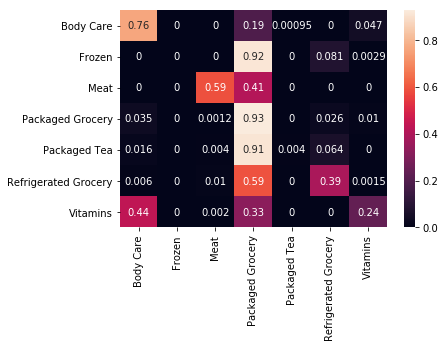

In [25]:
conf_mat = confusion_matrix(y, cv_predictions, labels=np.sort(y.unique()))
conf_mat_df = pd.DataFrame(
    conf_mat, 
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

conf_mat_props = pd.DataFrame(
    conf_mat_df.values / conf_mat_df.sum(axis=1)[:,None],
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

sns.heatmap(conf_mat_props, annot=True);

In [26]:
conf_mat_props.apply(lambda x: (x == 0).sum()).mean()

3.0

There are considerably more zero-valued entries in the confusion matrix compared to the KNN and SVM models and, consequently, more instances are mis-classified as belonging to the Package Grocery class.  We might consider developing features that can more clearly differentiate Packaged Grocery from other categories or other categories from Packaged Grocery.

#### Learning Curve

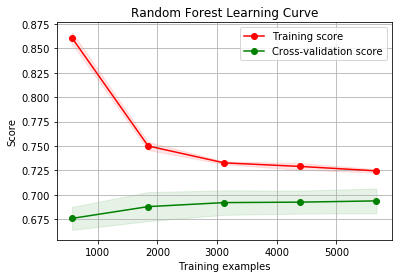

In [27]:
# Plot the learning curve
plot_learning_curve(model.get_model_pipeline(), 'Random Forest Learning Curve', X, y, cv=CV);

The model appears to be suffering from both low bias and high variance - even with a training score of 72%, there are too many mis-classifications for this model to be useful.